In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import cv2
import imageio
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import torch
import cmath
from run_VAE import sites_NOVEMBER, RAW_NOVEMBER, INTERMEDIATE_NOVEMBER
from HiddenStateExtractor.cv2_feature import get_density, get_angle_apr, get_aspect_ratio_no_rotation
from HiddenStateExtractor.vq_vae import VQ_VAE, rescale
plt.switch_backend('module://ipykernel.pylab.backend_inline')

In [4]:
sites = sites_NOVEMBER
RAW_NOVEMBER = '/mnt/comp_micro/Projects/learningCellState/microglia/raw_for_segmentation/NOVEMBER/raw'
INTERMEDIATE_NOVEMBER = '/mnt/comp_micro/Projects/learningCellState/microglia/raw_for_segmentation/NOVEMBER/supp'
wells = {'B4', 'B5', 'B2', 'C5', 'C4'}
wells_ = {'B4', 'B5', 'B2', 'C5'}

raw_folder = RAW_NOVEMBER
supp_folder = INTERMEDIATE_NOVEMBER

In [55]:
# ### Load All Data ###
# dats = {}
# fs = {}
# traj_inds = {}
# trajs = {}
# traj_positions = {}
# traj_mg_ratios = {}
# for well in wells:
#     path = os.path.join(raw_folder, '%s_latent_space_PCAed.pkl' % well)
#     dats[well] = pickle.load(open(path, 'rb'))
    
#     path = os.path.join(raw_folder, '%s_file_paths.pkl' % well)
#     fs[well] = pickle.load(open(path, 'rb'))

#     well_sites = [s for s in sites if s.startswith(well)]
#     for site in well_sites:
#         print(site)
#         path = os.path.join(supp_folder, '%s-supps' % well, '%s' % site, 'cell_traj.pkl')
#         cell_trajectories_inds, cell_trajectories_positions = pickle.load(open(path, 'rb'))

#         path = os.path.join(supp_folder, '%s-supps' % well, '%s' % site, 'cell_pixel_assignments.pkl')
#         cell_pixel_assignments = pickle.load(open(path, 'rb'))

#         path = os.path.join(raw_folder, '%s_NNProbabilities.npy' % site)
#         segmentation_stack = np.load(path)

#         for i, (t, t_pos) in enumerate(zip(cell_trajectories_inds, cell_trajectories_positions)):
#             ratios = []
#             for t_point in t:
#                 cell_id = t[t_point]
#                 inds = np.where(cell_pixel_assignments[t_point][1] == cell_id)
#                 cell_pixels = cell_pixel_assignments[t_point][0][inds]
#                 cell_segmentation = segmentation_stack[t_point][(cell_pixels[:, 0], cell_pixels[:, 1])]
#                 mg_ratio = (cell_segmentation[:, 1] > 0.5).sum() / cell_segmentation.shape[0]
#                 ratios.append(mg_ratio)            

#             trajs[site + '/%d' % i] = t
#             traj_positions[site + '/%d' % i] = t_pos
#             traj_mg_ratios[site + '/%d' % i] = ratios
#     path = os.path.join(raw_folder, '%s_trajectories.pkl' % well)
#     well_traj_inds = pickle.load(open(path, 'rb'))
#     traj_inds.update({k: v for k, v in well_traj_inds.items() if k in trajs})

In [77]:
# _trajs = {}
# _traj_positions = {}
# _traj_inds = {}
# for t_name, ratios in traj_mg_ratios.items():
#     well = t_name[:2]
#     if not well in wells_:
#         continue
#     if np.percentile(ratios, 50) < 0.5:        
#         for start in range(len(ratios)):
#             if ratios[start] < 0.2:
#                 break
#         for end in range(len(ratios)-1, 0, -1):
#             if ratios[end] < 0.2:
#                 break
# #         print("%d\t%d" % (start, end))
        
#         if end - start < 10:
#             continue
#         t_points = sorted(trajs[t_name].keys())
#         valid_t_points = t_points[start:(end+1)]
#         _trajs[t_name] = {k: v for k,v in trajs[t_name].items() if k in valid_t_points}
#         _traj_positions[t_name] = {k: v for k,v in traj_positions[t_name].items() if k in valid_t_points}
#         _traj_inds[t_name] = traj_inds[t_name][start:(end+1)]
#         assert len(_traj_inds[t_name]) == len(_trajs[t_name])

# with open('NOVEMBER_dat_nonmg_save.pkl', 'wb') as f:
#     pickle.dump([None, None, _traj_inds, _trajs, _traj_positions], f)

In [138]:
dats, fs, mg_traj_inds, mg_trajs, mg_traj_positions = pickle.load(open('NOVEMBER_dat_save.pkl', 'rb'))
_, _, traj_inds, trajs, traj_positions = pickle.load(open('NOVEMBER_dat_nonmg_save.pkl', 'rb'))

In [140]:
### Define Extra Functions ###
phase_a = 2.
phase_b = -50000.

legends = {
    'B2': 'GBM',
    'B4': 'IL17',
    'B5': 'IFN beta',
    'C4': 'Rubella',
    'C5': 'Control'
}

def hex_to_rgb(s):
    s = s.lstrip('#')
    s = list(int(s[i:i+2], 16)/256. for i in (0, 2, 4)) + [1.] # hex to rgb
    return s

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def generate_color_vectors(start, end, N=256):
    start = hex_to_rgb(start)
    end = hex_to_rgb(end)
    output = np.zeros((N, 4))
    for i in range(4):
        output[:, i] = np.linspace(start[i], end[i], N)
    return output

cmaps = {
    'B2': ListedColormap(generate_color_vectors('#ffffff', '#438548')),
    'B4': ListedColormap(generate_color_vectors('#ffffff', '#ce103d')),
    'B5': ListedColormap(generate_color_vectors('#ffffff', '#d44d00')),
    'C4': ListedColormap(generate_color_vectors('#ffffff', '#f0ba00')),
    'C5': ListedColormap(generate_color_vectors('#ffffff', '#005082')),
    'all': ListedColormap(generate_color_vectors('#ffffff', '#111111'))
}

colors = {w: cmaps[w](0.8) for w in cmaps}

def enhance_contrast(mat, a=1.5, b=-10000):
  mat2 = cv2.addWeighted(mat, a, mat, 0, b)
  return mat2

def save_movie(traj, path):
  well = traj[:2]
  site = traj.split('/')[0]
  stacks = []
  for ind in traj_inds[traj]:
    f = fs[well][ind]
    p = os.path.join(supp_folder, '%s-supps' % well, '%s' % site, 'stacks_%s.pkl' % f.split('/')[-1].split('_')[0])
    mat = pickle.load(open(p, 'rb'))[f]['mat'][:, :, 0]
    mat2 = np.clip(enhance_contrast(mat, phase_a, phase_b), 0, 65535).astype('uint16')
    stacks.append(mat2)
  output = (np.stack(stacks, 0).astype('float')/256).astype('uint8')
  imageio.mimsave(path, output)

def save_traj_bbox(traj, path):
  output_images = np.zeros((len(traj_inds[traj]), 512, 512))
  site = traj.split('/')[0]
  image_stack = np.load(os.path.join(raw_folder, '%s.npy' % site))
  for i, k in enumerate(sorted(trajs[traj].keys())):
    mat = cv2.resize(image_stack[k, :, :, 0], (512, 512))
    output_images[i] = np.clip(enhance_contrast(mat, phase_a, phase_b), 0, 65535).astype('uint16')

  output_images = np.stack([output_images] * 3, 3)
  output_images = output_images / 65535.

  for i, k in enumerate(sorted(trajs[traj].keys())):
    box_center = traj_positions[traj][k] / (2048/512)
    box_range = [(max(box_center[0] - 16., 0), min(box_center[0] + 16., 512)),
                 (max(box_center[1] - 16., 0), min(box_center[1] + 16., 512))]
    
    # Left edge
    x = box_range[0][0]
    x_ = (int(max(x - 1., 0)), int(min(x + 1., 512)))
    output_images[i, x_[0]:x_[1], int(box_range[1][0]):int(box_range[1][1])] = np.array([1., 0., 0.]).reshape((1, 1, 3))
    # Right edge
    x = box_range[0][1]
    x_ = (int(max(x - 1., 0)), int(min(x + 1., 512)))
    output_images[i, x_[0]:x_[1], int(box_range[1][0]):int(box_range[1][1])] = np.array([1., 0., 0.]).reshape((1, 1, 3))
    # Top edge
    y = box_range[1][0]
    y_ = (int(max(y - 1., 0)), int(min(y + 1., 512)))
    output_images[i, int(box_range[0][0]):int(box_range[0][1]), y_[0]:y_[1]] = np.array([1., 0., 0.]).reshape((1, 1, 3))
    # Bottom edge
    y = box_range[1][1]
    y_ = (int(max(y - 1., 0)), int(min(y + 1., 512)))
    output_images[i, int(box_range[0][0]):int(box_range[0][1]), y_[0]:y_[1]] = np.array([1., 0., 0.]).reshape((1, 1, 3))
  # tifffile.imwrite(path, (output_images*255).astype('uint8'))
  imageio.mimwrite(path, (output_images*255).astype('uint8'))
  return

In [141]:
### Process Data and Generate Trajectory Summaries ###
t_lag = 1
bins_PC1 = np.linspace(-4, 6, 20)
bins_PC2 = np.linspace(-3, 8, 20)
bins_speed = np.linspace(1.0, 5.2, 20) # Log um/h scale

patch_PC1 = {well: dats[well][:, 0] for well in wells}
patch_PC2 = {well: dats[well][:, 1] for well in wells}

traj_PC1 = {well: [] for well in wells}
traj_PC2 = {well: [] for well in wells}
traj_speed = {well: [] for well in wells}
traj_names = {well: [] for well in wells}
for t in trajs:
    well = t[:2]
    if not well in wells:
        continue
    traj_names[well].append(t)
    traj_PC1[well].append(np.mean([dats[well][ind, 0] for ind in traj_inds[t]]))
    traj_PC2[well].append(np.mean([dats[well][ind, 1] for ind in traj_inds[t]]))

    t_keys = sorted(trajs[t].keys())
    dists = []
    for t_point in t_keys:
        if (t_point + t_lag) in t_keys:
            d = np.linalg.norm(traj_positions[t][t_point+t_lag] - \
                               traj_positions[t][t_point], ord=2)
            dists.append(d)    
    traj_speed[well].append(np.log(np.mean(dists) * 0.325 / 0.1518)) # Unit of pixel(0.325um) per frame(9.11 min) to um per hour

In [142]:
### Calculate Cell Motion Directions ###

cell_aps = pickle.load(open(os.path.join(raw_folder, 'all_patches_cell_aspect_ratios.pkl'), 'rb'))
traj_orientations = {}
traj_orientations2 = {}
traj_orientation_stds = {}
patch_orientations = {}
patch_displacements = {}
t_lag = 1

angs1_all = []
angs2_all = []
ang_diffs_all = []
for t in traj_inds:
    well = t[:2]
    traj_fs = [fs[well][ind] for ind in traj_inds[t]]
    t_keys = sorted(trajs[t].keys())
    
    valid_fs = []
    ds = []
    d_angs = []
    for i, f in enumerate(traj_fs):
        t_point = t_keys[i]
        if (t_point + t_lag) in t_keys:
            d = np.linalg.norm(traj_positions[t][t_point+t_lag] - \
                               traj_positions[t][t_point], ord=2)
            d_ang = traj_positions[t][t_point+t_lag] - traj_positions[t][t_point]
            d_ang = cmath.polar(complex(d_ang[1], d_ang[0]))[1]
            valid_fs.append(f)
            ds.append(d)
            d_angs.append(d_ang)

    traj_cell_aps = [cell_aps[f][0] for f in valid_fs]
    traj_cell_angs = [cell_aps[f][1] for f in valid_fs]

    angs1 = [a for i, a in enumerate(d_angs) if traj_cell_aps[i] > 1.1] # Orientation of movement, 0 ~ 2pi
    angs2 = [a for i, a in enumerate(traj_cell_angs) if traj_cell_aps[i] > 1.1]
    angs2 = [a if a > 0 else a + np.pi for a in angs2] # Orientation of cell long axis, 0~pi
    angs1_all.extend(angs1)
    angs2_all.extend(angs2)
    ds = [d for i, d in enumerate(ds) if traj_cell_aps[i] > 1.1]
    valid_fs_ = [f for i, f in enumerate(valid_fs) if traj_cell_aps[i] > 1.1]
    if len(angs1) <= 2:
        continue
    
    ang_diffs = [(a1 - a2)%(np.pi) for a1, a2 in zip(angs1, angs2)]
    #ang_diffs = [a if a < np.pi/2 else a - np.pi for a in ang_diffs]
    ang_diffs_all.extend(ang_diffs)
    for f, a in zip(valid_fs_, ang_diffs):
        patch_orientations[f] = a
    for f, d in zip(valid_fs_, ds):
        patch_displacements[f] = d
    
    # Pool angles along the traj
    merged_x = sum([d * np.cos(2 * ang) for d, ang in zip(ds, ang_diffs)])
    merged_y = sum([d * np.sin(2 * ang) for d, ang in zip(ds, ang_diffs)])
    merged_d, merged_ang_diff = cmath.polar(complex(merged_x, merged_y))
    
    assert np.allclose(merged_d, np.sqrt(merged_x**2 + merged_y**2))
    traj_orientations[t] = merged_ang_diff / 2
    traj_orientations2[t] = np.arctan(merged_y/merged_x) / 2
    traj_orientation_stds[t] = merged_d/sum(ds)


In [121]:
### Calculate Cell Motion Directions ###

cell_aps = pickle.load(open(os.path.join(raw_folder, 'all_patches_cell_aspect_ratios.pkl'), 'rb'))
mg_traj_orientations = {}
mg_traj_orientations2 = {}
mg_traj_orientation_stds = {}
patch_orientations = {}
patch_displacements = {}
t_lag = 1

angs1_all = []
angs2_all = []
ang_diffs_all = []
for t in mg_traj_inds:
    well = t[:2]
    mg_traj_fs = [fs[well][ind] for ind in mg_traj_inds[t]]
    t_keys = sorted(mg_trajs[t].keys())
    
    valid_fs = []
    ds = []
    d_angs = []
    for i, f in enumerate(mg_traj_fs):
        t_point = t_keys[i]
        if (t_point + t_lag) in t_keys:
            d = np.linalg.norm(mg_traj_positions[t][t_point+t_lag] - \
                               mg_traj_positions[t][t_point], ord=2)
            d_ang = mg_traj_positions[t][t_point+t_lag] - mg_traj_positions[t][t_point]
            d_ang = cmath.polar(complex(d_ang[1], d_ang[0]))[1]
            valid_fs.append(f)
            ds.append(d)
            d_angs.append(d_ang)

    mg_traj_cell_aps = [cell_aps[f][0] for f in valid_fs]
    mg_traj_cell_angs = [cell_aps[f][1] for f in valid_fs]

    angs1 = [a for i, a in enumerate(d_angs) if mg_traj_cell_aps[i] > 1.1] # Orientation of movement, 0 ~ 2pi
    angs2 = [a for i, a in enumerate(mg_traj_cell_angs) if mg_traj_cell_aps[i] > 1.1]
    angs2 = [a if a > 0 else a + np.pi for a in angs2] # Orientation of cell long axis, 0~pi
    angs1_all.extend(angs1)
    angs2_all.extend(angs2)
    ds = [d for i, d in enumerate(ds) if mg_traj_cell_aps[i] > 1.1]
    valid_fs_ = [f for i, f in enumerate(valid_fs) if mg_traj_cell_aps[i] > 1.1]
    if len(angs1) <= 2:
        continue
    
    ang_diffs = [(a1 - a2)%(np.pi) for a1, a2 in zip(angs1, angs2)]
    #ang_diffs = [a if a < np.pi/2 else a - np.pi for a in ang_diffs]
    ang_diffs_all.extend(ang_diffs)
    for f, a in zip(valid_fs_, ang_diffs):
        patch_orientations[f] = a
    for f, d in zip(valid_fs_, ds):
        patch_displacements[f] = d
    
    # Pool angles along the traj
    merged_x = sum([d * np.cos(2 * ang) for d, ang in zip(ds, ang_diffs)])
    merged_y = sum([d * np.sin(2 * ang) for d, ang in zip(ds, ang_diffs)])
    merged_d, merged_ang_diff = cmath.polar(complex(merged_x, merged_y))
    
    assert np.allclose(merged_d, np.sqrt(merged_x**2 + merged_y**2))
    mg_traj_orientations[t] = merged_ang_diff / 2
    mg_traj_orientations2[t] = np.arctan(merged_y/merged_x) / 2
    mg_traj_orientation_stds[t] = merged_d/sum(ds)


In [210]:
np.random.seed(123)
samples = np.random.choice(list(trajs.keys()), (10,), replace=False)
for s in samples:
    print(s)
    save_traj_bbox(s, 'temp/sample_%s.gif' % s.replace('/', '_'))

B2-Site_1/111
B4-Site_0/129
C5-Site_1/386
B4-Site_0/202
B5-Site_2/107
B5-Site_1/53
B5-Site_1/59
B4-Site_2/261
B4-Site_6/83
B5-Site_1/145


In [211]:
os.getcwd()

'/data/michaelwu/CellVAE'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

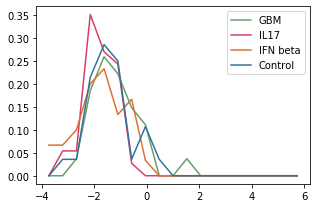

In [144]:
plt.clf()
f = plt.figure(figsize=(4.5, 3))
for well in wells_:
    freqs, bins = np.histogram(traj_PC1[well], bins=bins_PC1)
    freqs = freqs/freqs.sum()
    x = (bins[:-1] + bins[1:])/2
    plt.plot(x, freqs, c=colors[well], label=legends[well])
plt.xlabel("")
plt.ylabel("")
plt.legend()
plt.grid(b=False, which='major', axis='x')
plt.tight_layout()
plt.savefig('temp/NOVEMBER_nonmg_PC1.eps')
plt.savefig('temp/NOVEMBER_nonmg_PC1.png', dpi=300)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

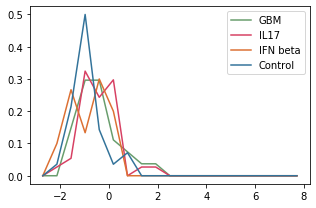

In [145]:
plt.clf()
f = plt.figure(figsize=(4.5, 3))
for well in wells_:
    freqs, bins = np.histogram(traj_PC2[well], bins=bins_PC2)
    freqs = freqs/freqs.sum()
    x = (bins[:-1] + bins[1:])/2
    plt.plot(x, freqs, c=colors[well], label=legends[well])
plt.xlabel("")
plt.ylabel("")
plt.legend()
plt.grid(b=False, which='major', axis='x')
plt.tight_layout()
plt.savefig('temp/NOVEMBER_nonmg_PC2.eps')
plt.savefig('temp/NOVEMBER_nonmg_PC2.png', dpi=300)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

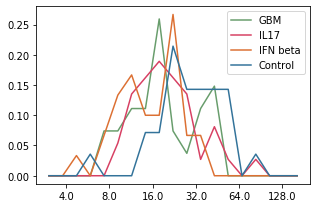

In [146]:
plt.clf()
f = plt.figure(figsize=(4.5, 3))
for well in wells_:
    freqs, bins = np.histogram(traj_speed[well], bins=bins_speed)
    freqs = freqs/freqs.sum()
    x = (bins[:-1] + bins[1:])/2
    plt.plot(x, freqs, c=colors[well], label=legends[well])
plt.xlabel("")
plt.ylabel("")
plt.legend()
plt.grid(b=False, which='major', axis='x')
speed_ticks = [4., 8., 16., 32., 64., 128.]
plt.gca().set_xticks(np.log(speed_ticks))
plt.gca().set_xticklabels(speed_ticks)
plt.tight_layout()
plt.savefig('temp/NOVEMBER_nonmg_speed.eps')
plt.savefig('temp/NOVEMBER_nonmg_speed.png', dpi=300)



In [190]:
### GMM to multiple states ###
t_lag = 1
mg_traj_properties = {}
X = []
Y = []
mg_t_arrays = []
for t in mg_trajs:
    well = t[:2]
    if not well in wells_:
        continue
    t_keys = sorted(mg_trajs[t].keys())
    dists = []
    for t_point in t_keys:
        if (t_point + t_lag) in t_keys:
            d = np.linalg.norm(mg_traj_positions[t][t_point+t_lag] - \
                               mg_traj_positions[t][t_point], ord=2)
            dists.append(d)
        
    mg_traj_PC = [dats[well][ind] for ind in mg_traj_inds[t]]
    mg_traj_dist = dists
    mg_traj_properties[t] = (mg_traj_PC, mg_traj_dist)
    X.append(np.concatenate([np.array(np.log(np.mean(mg_traj_dist) * 0.325 / 0.1518)).reshape((-1,)), np.mean(mg_traj_PC, 0)]))
    Y.append(sorted(wells_).index(well))
    mg_t_arrays.append(t)
    
mg_X = np.array(X)
mg_Y = np.array(Y)
std_unit = np.std(X, 0)
std_unit = np.clip(std_unit, 0.6, 10.)
# std_unit[1:] = np.clip(std_unit[1:], std_unit[1], 10.)

In [191]:
### Non-MG cell properties ###
t_lag = 1
nonmg_traj_properties = {}
X = []
Y = []
t_arrays = []
for t in trajs:
    well = t[:2]
    if not well in wells_:
        continue
    t_keys = sorted(trajs[t].keys())
    dists = []
    for t_point in t_keys:
        if (t_point + t_lag) in t_keys:
            d = np.linalg.norm(traj_positions[t][t_point+t_lag] - \
                               traj_positions[t][t_point], ord=2)
            dists.append(d)
        
    traj_PC = [dats[well][ind] for ind in traj_inds[t]]
    traj_dist = dists
    nonmg_traj_properties[t] = (traj_PC, traj_dist)
    X.append(np.concatenate([np.array(np.log(np.mean(traj_dist) * 0.325 / 0.1518)).reshape((-1,)), np.mean(traj_PC, 0)]))
    Y.append(sorted(wells_).index(well))
    t_arrays.append(t)
    
X = np.array(X)
Y = np.array(Y)

state_cmaps = [plt.get_cmap(name) for name in ['Blues', 'Reds', 'Greens', 'Oranges']]
traj_states = {well: [] for well in wells_}
prob_mat = get_merged_prob_mat(X, Y, centers, stds, well_prob_mat)
for well in wells_:
    names = traj_names[well]
    for n in names:
        traj_states[well].append(prob_mat[t_arrays.index(n)])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

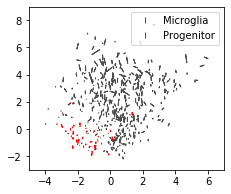

In [208]:
speed_ticks = [4., 8., 16., 32., 64., 128.]

plt.clf()
f = plt.figure(figsize=(3.5, 3))

random_selected_inds = np.random.choice(np.arange(len(mg_X)), (400,), replace=False)
for i in random_selected_inds:
    t = mg_t_arrays[i]
    merged_ang_diff = mg_traj_orientations[t]
    merged_d = np.exp(mg_X[i, 0])/200
    #merged_d = (1 - traj_orientation_stds[t])/2 # Longer marker indicates more consistent movement (smaller circular SD)
    arrow_vec = (merged_d * np.sin(merged_ang_diff), merged_d * np.cos(merged_ang_diff))
    x_center = mg_X[i, 1]
    y_center = mg_X[i, 2]
    dx = arrow_vec[0]
    dy = arrow_vec[1]
    x = x_center - dx/2
    y = y_center - dy/2
    plt.arrow(x, y, dx, dy, color=(0.3, 0.3, 0.3), width=0.005, head_width=0.)

random_selected_inds = np.random.choice(np.arange(len(X)), (50,), replace=False)
for i in random_selected_inds:
    t = t_arrays[i]
    if not t in traj_orientations:
        continue
    merged_ang_diff = traj_orientations[t]
    merged_d = np.exp(X[i, 0])/200
    #merged_d = (1 - traj_orientation_stds[t])/2 # Longer marker indicates more consistent movement (smaller circular SD)
    arrow_vec = (merged_d * np.sin(merged_ang_diff), merged_d * np.cos(merged_ang_diff))
    x_center = X[i, 1]
    y_center = X[i, 2]
    dx = arrow_vec[0]
    dy = arrow_vec[1]
    x = x_center - dx/2
    y = y_center - dy/2
    plt.arrow(x, y, dx, dy, color='r', width=0.005, head_width=0.)

plt.xlabel("")
plt.ylabel("")
plt.xlim(-5, 7)
plt.ylim(-3, 9)

import matplotlib.patches as mpatches
plt.plot([-10], [-1], '|', color=(0.3, 0.3, 0.3), label='Microglia')
plt.plot([-10], [-1], '|', color='r', label='Progenitor')
plt.legend()

plt.savefig('temp/NOVEMBER_mg_nonmg_PC12.eps')
plt.savefig('temp/NOVEMBER_mg_nonmg_PC12.png', dpi=300)

In [195]:
### UMAP of morphodynamic features ###
import umap
import matplotlib.pyplot as plt
import pickle
n = 10
d = 0.1
mg_X_ = mg_X/std_unit
X_ = X/std_unit
combined_X_ = np.concatenate([mg_X_, X_], 0)
reducer = umap.UMAP(n_neighbors=n, min_dist=d)
embedding = reducer.fit_transform(combined_X_)

In [196]:
embedding_mg = embedding[:len(mg_X_)]
embedding_nonmg = embedding[len(mg_X_):]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

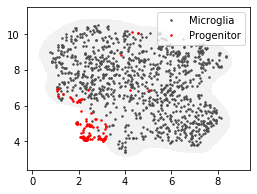

In [209]:
from scipy.stats import gaussian_kde
def density_estimation(m1, m2):
    xmin, xmax = m1.min()-0.5, m1.max()+0.5
    ymin, ymax = m2.min()-0.5, m2.max()+0.5
    xint = (xmax - xmin) / 100
    yint = (ymax - ymin) / 100
    X, Y = np.mgrid[xmin:xmax:xint, ymin:ymax:yint]
    positions = np.stack([X.ravel(), Y.ravel()], 0)
    values = np.stack([m1, m2], 0)
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions), X.shape)
    return X, Y, Z

m1, m2 = embedding_mg[:, 0], embedding_mg[:, 1]
cont_X, cont_Y, cont_Z = density_estimation(m1, m2)
xmin, xmax = m1.min()-0.5, m1.max()+0.5
ymin, ymax = m2.min()-0.5, m2.max()+0.5

plt.clf()
f = plt.figure(figsize=(4, 3))

selected_inds = np.random.choice(np.arange(len(embedding_mg)), (1000,), replace=False)
plt.plot(embedding_mg[selected_inds][:, 0], 
         embedding_mg[selected_inds][:, 1], 
         '.',
         c=(0.3, 0.3, 0.3), 
         markersize=3.,
         label='Microglia')
plt.plot(embedding_nonmg[:, 0], 
         embedding_nonmg[:, 1], 
         '.',
         c='r', 
         markersize=3.,
         label='Progenitor')
plt.contourf(cont_X, cont_Y, cont_Z>cont_Z.max()*0.15, levels=1, colors=[(1., 1., 1.), (0.95, 0.95, 0.95)])
plt.xlim(xmin-0.5, xmax+0.5)
plt.ylim(ymin-0.5, ymax+0.5)
plt.legend()
plt.savefig('temp/NOVEMBER_mg_nonmg_umap.eps')
plt.savefig('temp/NOVEMBER_mg_nonmg_umap.png', dpi=300)